In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
import scipy.stats as st

In [2]:
from grid_method import *
from model import GHH
from architectures import *

In [8]:
def nb_region_arch3(ls, n_iter, window_size, nb, save_name):
    nbs = torch.empty(len(ls), n_iter)
    
    for j in range(len(ls)):
        l = ls[j]
        
        for i in range(n_iter):
            d = torch.linspace(-1*window_size, window_size, nb)
            d = d.reshape(-1, 1)
            d.requires_grad_(True)
            output = arch_3(d, 3, l)
            output.backward(torch.ones_like(output))
            grad = d.grad.numpy().reshape(-1)
            
            nbs[j,i] = len(set(grad))
        
        print(f'{l}, finished.')
    # save the result
    nbs_tosave = np.array(nbs)
    np.save(save_name, nbs_tosave)
    

In [9]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 2500
window_size = 40
nb = 8001
ls

array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50])

In [10]:
nb_region_arch3(ls, n_iter, window_size, nb, 'W12/arch3_nb_region.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.
25, finished.
30, finished.
35, finished.
40, finished.
45, finished.
50, finished.


In [11]:
nbs_arch3 = np.load('W12/arch3_nb_region.npy')

In [12]:
nbs_arch3

array([[ 14.,  11.,  13., ...,  12.,  11.,  14.],
       [  9.,  11.,  11., ...,  12.,  11.,  14.],
       [ 27.,  23.,  24., ...,  32.,  30.,  23.],
       ...,
       [132.,  91.,  60., ..., 188.,  90.,  62.],
       [114.,  79.,  44., ...,  53.,  44.,  29.],
       [ 75.,  65.,  80., ..., 381.,  82., 156.]], dtype=float32)

In [33]:
def nb_region_arch4(x_range, y_range, step, ls, n_iter, save_name):
    nbs = torch.empty(len(ls), n_iter)
    
    for j in range(len(ls)):
        l = ls[j]
        for i in range(n_iter):
            d, ll = generate_grid(x_range, y_range, step)
            d.requires_grad_(True)
            output = arch_4(d, 3, l)
            grad_x, grad_y = compute_grad(output, d, ll)
            reg = get_region_fast(grad_x, grad_y)
            
            nbs[j,i] = len(set(reg.flatten()))
        
        print(f'{l}, finished.')
    
    # save the result
    nbs_tosave = np.array(nbs)
    
    np.save(save_name, nbs_tosave)
    

In [34]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 2500
x_range = [-20,20]
y_range = [-20,20]
step = 0.05
ls

array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50])

In [40]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 1000
x_range = [-20,20]
y_range = [-20,20]
step = 0.05
nb_region_arch4(x_range, y_range, step, ls, n_iter, 'W12/arch4_nb_region.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.
25, finished.
30, finished.
35, finished.
40, finished.
45, finished.
50, finished.


In [36]:
nbs_arch4 = np.load('W12/arch4_nb_region.npy')
nbs_arch4

array([[  72.],
       [ 114.],
       [  91.],
       [ 260.],
       [ 632.],
       [ 408.],
       [ 711.],
       [ 599.],
       [1137.],
       [1329.],
       [2975.],
       [1058.],
       [1008.],
       [1622.],
       [ 630.],
       [ 567.],
       [ 503.]], dtype=float32)

In [6]:
def confidence_interval(arr):
    boot_means = []
    for _ in range(10000):
        bootsample = np.random.choice(arr, 100, replace = False)
        boot_mean = bootsample.mean()
        boot_means.append(boot_mean)
        
    ci = np.array([np.percentile(boot_means, 5), np.percentile(boot_means, 95)])
    return ci

In [15]:
import scipy.stats as st 
def confidence_interval(arr):
    ci = np.array(st.norm.interval(alpha=0.95, loc=np.mean(arr), scale=st.sem(arr)))
    return ci

In [11]:
data = np.random.randint(10, 30, 50000)
ci = np.array(st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data)))
ci

array([19.48235463, 19.58332537])

In [13]:
data = np.random.randint(10, 30, 50000)

In [16]:
confidence_interval(data)

array([19.42127865, 19.52236135])

In [20]:
nbs_arch3 = np.load('W12/arch3_nb_region.npy')
nbs_arch4 = np.load('W12/arch4_nb_region.npy')

In [29]:
interval_arch3 = np.empty((2, nbs_arch3.shape[0]))
interval_arch4 = np.empty((2, nbs_arch4.shape[0]))

for i in range(nbs_arch3.shape[0]):
    interval_arch3[:,i] = confidence_interval(nbs_arch3[i,:])
    
for i in range(nbs_arch4.shape[0]):
    interval_arch4[:,i] = confidence_interval(nbs_arch4[i,:])

In [13]:
d = torch.linspace(-1*40, 40, 8001)
d = d.reshape(-1,1)
d.requires_grad_(True)


tensor([[-40.0000],
        [-39.9900],
        [-39.9800],
        ...,
        [ 39.9800],
        [ 39.9900],
        [ 40.0000]], requires_grad=True)

In [14]:
model = GHH(d, 1, 3)

In [15]:
model.normalize(d, lip_c = 3)

In [16]:
output = model(d)
output.backward(torch.ones_like(output))
grad = d.grad
lips = grad.abs().max()
print(grad)

tensor([[ 3.0000],
        [ 3.0000],
        [ 3.0000],
        ...,
        [-2.1557],
        [-2.1557],
        [-2.1557]])


In [12]:
lips

tensor(2.0000)

In [41]:
for name, parameter in model.named_parameters():
    print(name, ': ', parameter)

layer.weight :  Parameter containing:
tensor([[-0.5205],
        [-0.4148],
        [ 0.2022],
        [-0.7053],
        [ 0.2930],
        [-0.6124]], requires_grad=True)
layer.bias :  Parameter containing:
tensor([-0.0070, -0.9657,  0.2542,  0.9870,  0.1929,  0.4105],
       requires_grad=True)
eps.weight :  Parameter containing:
tensor([[-1.,  1.,  1.]], requires_grad=True)


In [55]:
model.eps.weight = nn.Parameter((1/lips) * model.eps_weight)

In [56]:
model.eps.weight

Parameter containing:
tensor([[ 1.1362, -1.1362,  1.1362]], requires_grad=True)

In [7]:
d, ll = generate_grid([-40, 40], [-40, 40], 0.1)
d.requires_grad_(True)
model = GHH(d,2,3)
model.normalize(d, 2)
output = model(d)

grad_x, grad_y = compute_grad(output, d, ll)


In [8]:
(grad_x.pow(2) + grad_y.pow(2)).sqrt().max()

tensor(1.0000)

# plot the 2 missing architecture in the previous experiments

In [13]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))

In [14]:
ls

array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50])

In [15]:
nbs_arch3 = np.load('W12/arch3_nb_region.npy')
nbs_arch4 = np.load('W12/arch4_nb_region.npy')

In [18]:
interval_arch3 = np.empty((2, nbs_arch3.shape[0]))
interval_arch4 = np.empty((2, nbs_arch4.shape[0]))

for i in range(nbs_arch3.shape[0]):
    interval_arch3[:,i] = confidence_interval(nbs_arch3[i,:])
    
for i in range(nbs_arch4.shape[0]):
    interval_arch4[:,i] = confidence_interval(nbs_arch4[i,:])

In [19]:
nbs_arch3_mean = nbs_arch3.mean(axis = 1)
nbs_arch4_mean = nbs_arch4.mean(axis = 1)

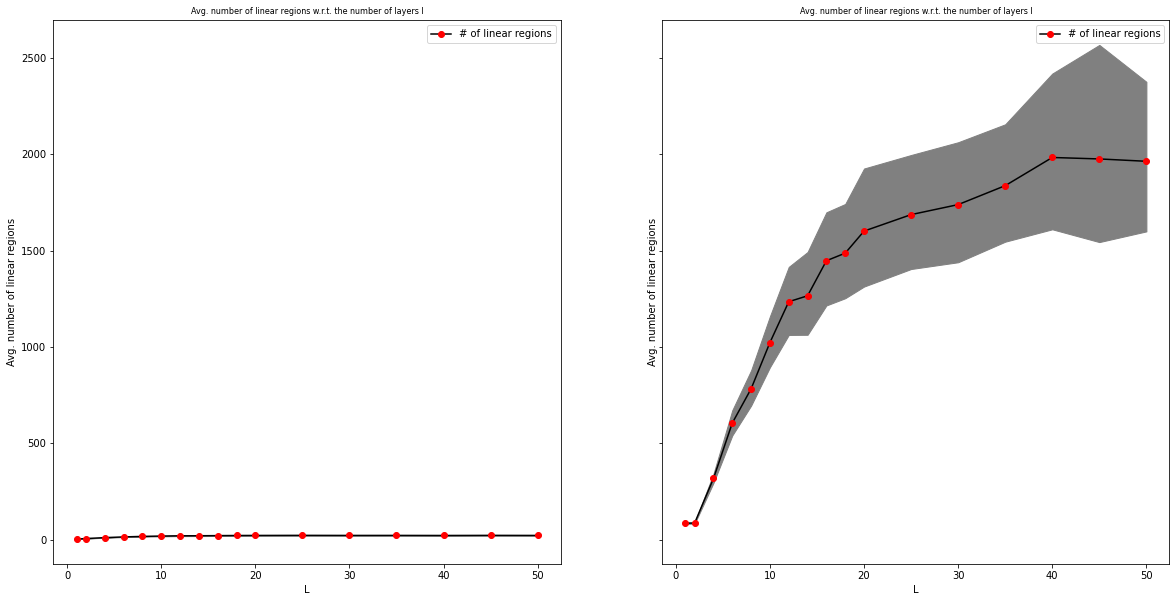

In [18]:
# plotting
fig,ax=plt.subplots(1, 2, figsize = (20,10), sharey=True)

ax1 = ax[0]
ax1.plot(ls,nbs_arch3_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
ax1.fill_between(ls, interval_arch3[0,:], interval_arch3[1,:], color='gray')
ax1.legend()

ax1.set_xlabel("L")
ax1.set_ylabel("Avg. number of linear regions")
ax1.set_title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)

ax2 = ax[1]
ax2.plot(ls,nbs_arch4_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
ax2.fill_between(ls, interval_arch4[0,:], interval_arch4[1,:], color='gray')
ax2.legend()

ax2.set_xlabel("L")
ax2.set_ylabel("Avg. number of linear regions")
ax2.set_title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)

plt.show()

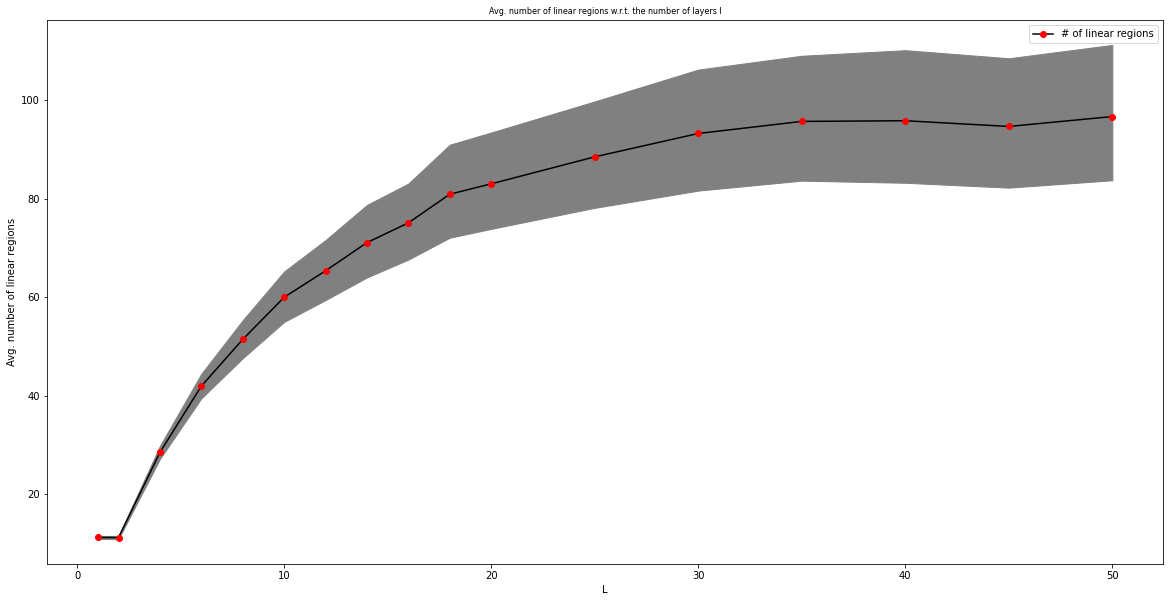

In [20]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,nbs_arch3_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, interval_arch3[0,:], interval_arch3[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)


plt.show()

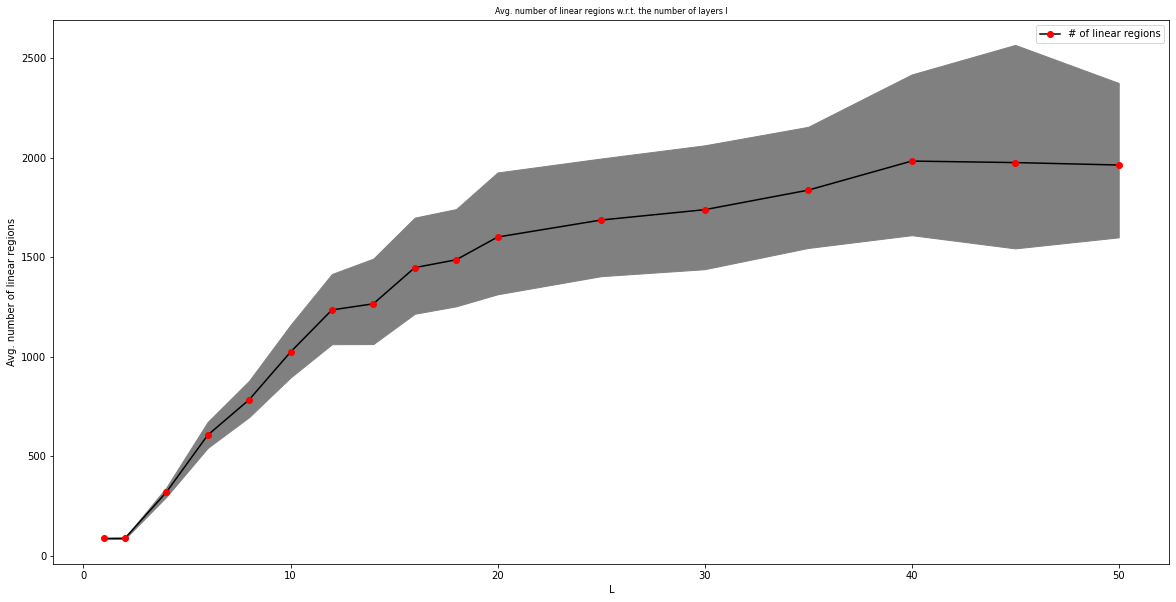

In [20]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,nbs_arch4_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, interval_arch4[0,:], interval_arch4[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)


plt.show()

In [6]:
def confidence_interval(arr):
    boot_means = []
    for _ in range(10000):
        bootsample = np.random.choice(arr, 100, replace = False)
        boot_mean = bootsample.mean()
        boot_means.append(boot_mean)
        
    ci = np.array([np.percentile(boot_means, 5), np.percentile(boot_means, 95)])
    return ci

In [9]:
ls = np.arange(0,21,3)[1:]
ls_add = np.arange(20,51,10)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))

In [10]:
nbs_arch2 = np.load('W12/nbs_2_norm.npy')
lips_arch2 = np.load('W12/lips_2_norm.npy')

nbs_arch2_mean = nbs_arch2.mean(axis = 1)
lips_arch2_mean = lips_arch2.mean(axis = 1)

nbs_interval_arch2 = np.empty((2, nbs_arch2.shape[0]))
lips_interval_arch2 = np.empty((2, lips_arch2.shape[0]))

for i in range(nbs_arch2.shape[0]):
    nbs_interval_arch2[:,i] = confidence_interval(nbs_arch2[i,:])
for i in range(lips_arch2.shape[0]):
    lips_interval_arch2[:,i] = confidence_interval(lips_arch2[i,:])

In [20]:
test = lips_arch2[9].ravel()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

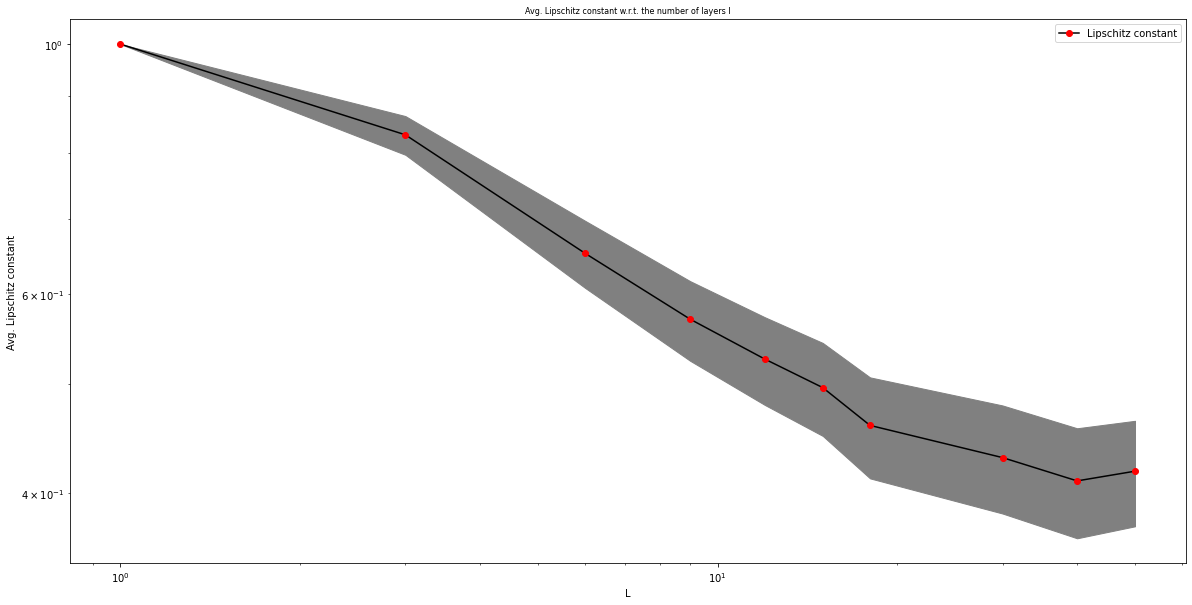

In [14]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,lips_arch2_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = 'Lipschitz constant')
plt.fill_between(ls, lips_interval_arch2[0,:], lips_interval_arch2[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Avg. Lipschitz constant")
plt.title("Avg. Lipschitz constant w.r.t. the number of layers l",fontsize=8)


plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,lips_arch1_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = 'Lipschitz constant')
plt.fill_between(ls, lips_interval_arch1[0,:], lips_interval_arch1[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. Lipschitz constant")
plt.title("Avg. Lipschitz constant w.r.t. the number of layers l",fontsize=8)


plt.show()